# HANK with investment

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Q2](#toc2_)    
  - 2.1. [a) Monetary policy without investment](#toc2_1_)    
  - 2.2. [b) Decompose HANK C response](#toc2_2_)    
  - 2.3. [c) Model with investment](#toc2_3_)    
  - 2.4. [d) Sticky expectations](#toc2_4_)    
- 3. [Q3 - Fiscal Policy](#toc3_)    
  - 3.1. [a)](#toc3_1_)    
  - 3.2. [b) - Vary deficit financing](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})
from HANKModel import HANKModelClass
import numba as nb 

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model_K = HANKModelClass(name='baseline')
model_K.find_ss(do_print=False)
model_K._compute_jac_hh()
model_K.calc_MPC()

c:\Users\fcv495\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


 message: The solution converged.
 success: True
  status: 1
     fun: [-1.169e-09  7.988e-14]
       x: [ 9.763e-01  9.947e-01]
    nfev: 6
    fjac: [[-5.325e-01  8.464e-01]
           [-8.464e-01 -5.325e-01]]
       r: [-1.785e+01 -1.177e+04 -1.867e+04]
     qtf: [ 5.570e-06  8.854e-06]
MPC = 0.35, iMPC[0,0] = 0.36
annual_MPC = 0.44


In [3]:
model_K.par.alpha,model_K.ss.G, model_K.ss.I

(0.2017004871114869, 0.1, 0.16)

In [4]:
model_K.par.beta_low,model_K.par.beta_high 

(0.9763050469279511, 0.9946843426842122)

In [5]:
model_K.ss.K, model_K.par.mu, model_K.ss.A_hh

(8.0, 1.01, 10.494988233701307)

In [6]:
print(model_K.ss.clearing_Y, model_K.ss.clearing_A)

2.922584174669396e-09 -1.1693899182319e-09


In [7]:
model_K.test_path()

shocks: G eps_i 
unknowns: pi L K 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.central_bank
  i                0.0e+00
  r                0.0e+00
 blocks.production
  w                0.0e+00
  Y                0.0e+00
  rK               0.0e+00
  I                1.4e-16
  Div              1.4e-16
  K_foc            0.0e+00 [target]
  pi_w             0.0e+00
 blocks.mutual_fund
  ra               1.1e-10
  pD               5.3e-15
 blocks.government
  chi              0.0e+00
  B                0.0e+00
  Taxes            0.0e+00
  Z                0.0e+00
  tau              0.0e+00
 hh
  A_hh             6.8e-07
  C_hh             4.5e-09
 blocks.NKWC
  NKWC_res         5.7e-11 [target]
 blocks.market_clearing
  clearing_A       6.8e-07 [target]
  clearing_Y       4.5e-09


Create RANK model 

In [8]:
def create_RANK_model(model_HA):
    model_RA = model_HA.copy()
    model_RA.par.HH_type = 'RANK'

    # Get Jacobian of RA model 
    M_RA = model_RA.get_RA_J()

    # overwrite HH jacobian such that GEModelTools uses RA jac 
    # Note that if you recompute the HH jacobian (model.compute_jac_hh() or model.compute_jacs() without the keyword "skip_hh=False") then this gets overwritten
    # and the model is effectively HANK again 
    
    for o in ['C_hh', 'A_hh']:
        for i in ['Z', 'ra', 'chi']:
            model_RA.jac_hh[(o,i)] = M_RA[o][i]

    return model_RA

model_K_RA = create_RANK_model(model_K)

Models without capital 

In [9]:
model_NO_K = model_K.copy()
model_NO_K.par.phi_K = 100.

In [10]:
model_NO_K_RA = create_RANK_model(model_NO_K)

## 2. <a id='toc2_'></a>[Q2](#toc0_)

### 2.1. <a id='toc2_1_'></a>[a) Monetary policy without investment](#toc0_)

In [11]:
model_NO_K.compute_jacs(skip_hh=False,skip_shocks=False)
model_NO_K_RA.compute_jacs(skip_hh=True,skip_shocks=False)

model_NO_K.find_IRFs(shocks=['eps_i'],do_print=False)
model_NO_K_RA.find_IRFs(shocks=['eps_i'],do_print=False)

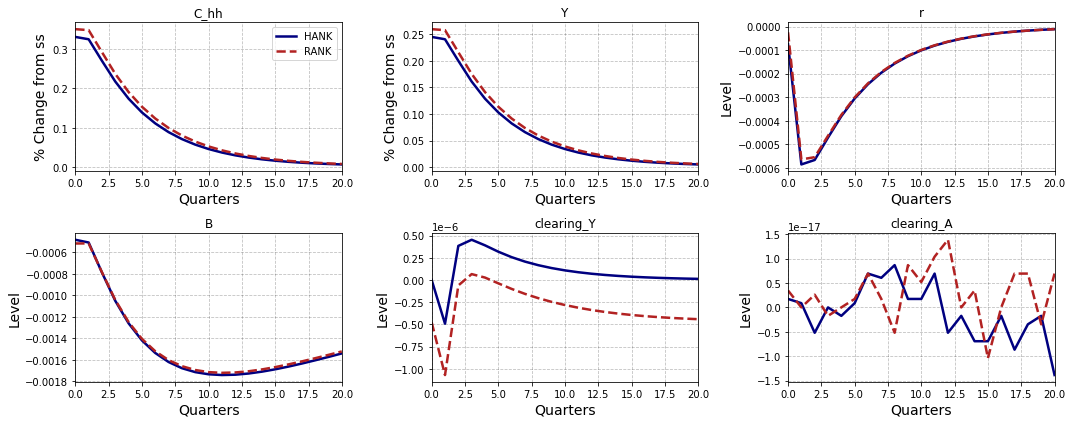

In [12]:
def plot_linear(model_list, names, paths, lvl_value=None, lw=2.5, T_max=21, 
                ncols=3, colors=['navy', 'firebrick'], ls=['-', '--'], facs={}):
    
    # Set default level value if not provided
    if lvl_value is None:
        lvl_value = []

    # Determine the number of subplots needed
    # n_models = len(model_list)
    nrows = (len(paths) + ncols - 1) // ncols

    # Create a figure and axes
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 3))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    # Loop through the variables to plot
    for idx, variable in enumerate(paths):
        
        if variable in facs:
            fac = facs[variable]
        else:
            fac = 1
        
        for model_idx, model in enumerate(model_list):
            # Calculate percentage change from steady state
            if variable in lvl_value:
                irf = model.IRF[variable][:T_max] * fac
            else:
                irf = model.IRF[variable][:T_max] / model.ss.__dict__[variable] * 100 * fac
            axes[idx].plot(irf, lw=lw, color=colors[model_idx], label=names[model_idx], linestyle=ls[model_idx])

        # Set plot titles and labels
        axes[idx].set_title(variable)
        axes[idx].set_xlim([0, T_max - 1])
        axes[idx].set_xlabel('Quarters', fontsize=14)
        
        if variable in lvl_value:
            axes[idx].set_ylabel('Level', fontsize=14)
        else:
            axes[idx].set_ylabel('% Change from ss', fontsize=14)
        
        
        if idx==0: axes[idx].legend()

    # Hide any extra subplots that are not needed
    for idx in range(len(paths), len(axes)):
        axes[idx].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


paths = ['C_hh', 'Y', 'r', 'B', 'clearing_Y', 'clearing_A']
plot_linear([model_NO_K,model_NO_K_RA], ['HANK','RANK'], paths, lvl_value=['pi', 'r', 'B', 'clearing_Y', 'clearing_A'],
            lw=2.5, T_max=21, ncols=3, colors=['navy', 'firebrick'])

### 2.2. <a id='toc2_2_'></a>[b) Decompose HANK C response](#toc0_)

In [13]:
def decomp_C(models, do_cap_gain=True, names=['RANK', 'HANK']): 
    
    results = {}
    # Loop through each model in the model_list
    for i, model in enumerate(models):
            
        # Compute dC_dZ
        dC_dZ = model.jac_hh[('C_hh', 'Z')] @ model.IRF['Z'] * 100 / model.ss.C_hh
        # Compute dC_dra
        dC_dra = model.jac_hh[('C_hh', 'ra')] @ model.IRF['ra'] * 100 / model.ss.C_hh

        # Compute dC_test
        dC_test = (dC_dZ + dC_dra) * 100 / model.ss.C_hh
        # Compute dC_tot
        dC_tot = model.IRF['C_hh'] / model.ss.C_hh * 100

        # Split into intertemporal substitution and capital gain components
        dra = model.IRF['ra']
        dC_dcap = model.jac_hh[('C_hh', 'ra')][:, 0] * dra[0] * 100 / model.ss.C_hh
        dC_dr = model.jac_hh[('C_hh', 'ra')][:, 1:] @ dra[1:] * 100 / model.ss.C_hh
    

        # Save the results in the dictionary for the current model
        results[names[i]] = {
            'dC_dZ': dC_dZ,
            'dC_dra': dC_dra,
            'dC_tot': dC_tot,
            'dC_dcap': dC_dcap,
            'dC_dr': dC_dr
        }

    # plot 
    lw = 2.5
    colors = ['navy', 'firebrick', 'forestgreen', 'orange']
    plot_test = False  

    if not do_cap_gain:
        fig, axes = plt.subplots(1, 2, figsize=(11, 4))

        # Plot data on the first subplot
        axes[0].plot(np.zeros(21), color='black')
        axes[0].plot(results[names[0]]['dC_tot'][:21], linewidth=lw, color=colors[0])
        axes[0].plot(results[names[0]]['dC_dZ'][:21], label='Z', linewidth=lw, color=colors[1])
        axes[0].plot(results[names[0]]['dC_dra'][:21], label='ra', linewidth=lw, color=colors[2])
        axes[0].set_title(names[0])
        axes[0].set_xlabel('Quarters')
        axes[0].set_ylabel('% change in C') 

        # Plot data on the second subplot
        axes[1].plot(np.zeros(21), color='black')
        axes[1].plot(results[names[1]]['dC_tot'][:21], label='Total', linewidth=lw, color=colors[0])
        if plot_test: axes[1].plot(dC_test[:21], label='Test', linestyle='--')
        axes[1].plot(results[names[1]]['dC_dZ'][:21], label='Z', linewidth=lw, color=colors[1])
        axes[1].plot(results[names[1]]['dC_dra'][:21], label='ra', linewidth=lw, color=colors[2])
        axes[1].set_title(names[1])
        axes[1].set_xlabel('Quarters')
        axes[1].set_ylabel('% change in C') 

        # Adjust layout to prevent overlap
        axes[1].legend()
        plt.tight_layout()

        # Show the plots
        plt.show()

    
    else:  # PLOT WITH CAPITAL GAIN 
        
        plot_test = False  

        fig, axes = plt.subplots(1, 2, figsize=(11, 4))

        # Plot data on the first subplot
        axes[0].plot(np.zeros(21), color='black')
        axes[0].plot(results[names[0]]['dC_tot'][:21], linewidth=lw, color=colors[0])
        axes[0].plot(results[names[0]]['dC_dZ'][:21], label='Z', linewidth=lw, color=colors[1])
        axes[0].plot(results[names[0]]['dC_dra'][:21], label='ra', linewidth=lw, color=colors[2])
        axes[0].set_title('RANK')
        axes[0].set_xlabel('Quarters')
        axes[0].set_ylabel('% change in C') 

        # Plot data on the second 
        axes[1].plot(np.zeros(21), color='black')
        axes[1].plot(results[names[1]]['dC_tot'][:21], label='Total', linewidth=lw, color=colors[0])
        axes[1].plot(results[names[1]]['dC_dZ'][:21], label='Z', linewidth=lw, color=colors[1])
        axes[1].plot(results[names[1]]['dC_dcap'][:21], label='Capital gain', linewidth=lw, color=colors[3], linestyle='--')
        axes[1].plot(results[names[1]]['dC_dr'][:21], label='Intertemporal sub.', linewidth=lw, color=colors[2])
        axes[1].set_title('HANK')
        axes[1].set_xlabel('Quarters')
        axes[1].set_ylabel('% change in C') 

        # Adjust layout to prevent overlap
        axes[1].legend()
        plt.tight_layout()

        # Show the plots
        plt.show()



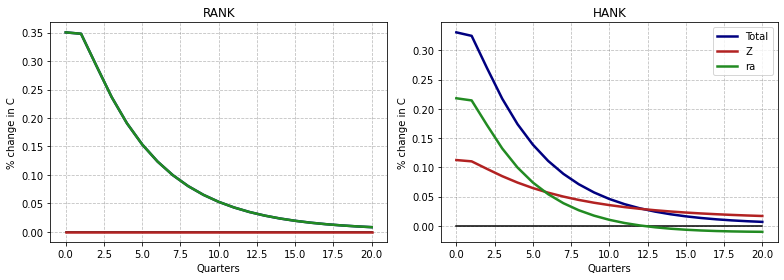

In [14]:
decomp_C([model_NO_K_RA, model_NO_K, ], names=['RANK', 'HANK'], do_cap_gain=False)

### 2.3. <a id='toc2_3_'></a>[c) Model with investment](#toc0_)

IRFs

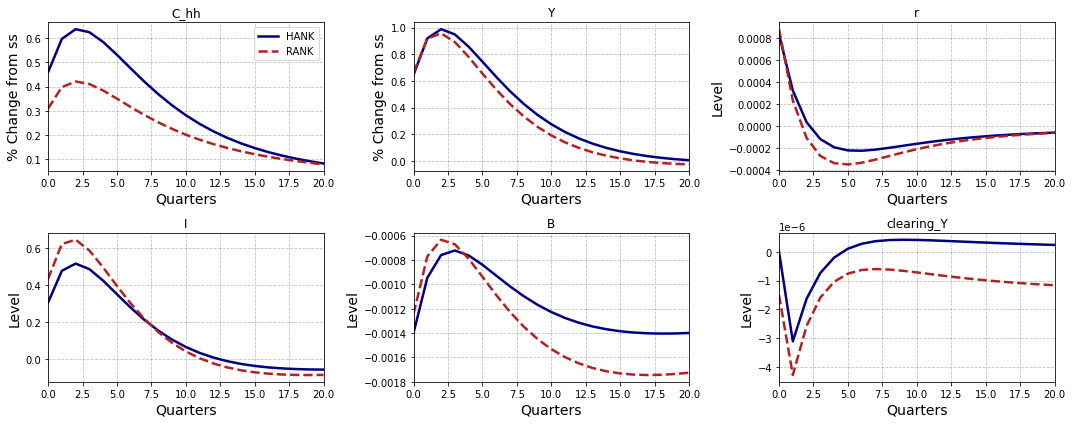

In [15]:
model_K.compute_jacs(skip_hh=False,skip_shocks=False)
model_K_RA.compute_jacs(skip_hh=True,skip_shocks=False)

model_K.find_IRFs(shocks=['eps_i'],do_print=False)
model_K_RA.find_IRFs(shocks=['eps_i'],do_print=False)

paths = ['C_hh', 'Y', 'r', 'I', 'B', 'clearing_Y']
plot_linear([model_K,model_K_RA], ['HANK','RANK'], paths, lvl_value=['pi', 'r', 'B', 'I', 'clearing_Y'],
            lw=2.5, T_max=21, ncols=3, colors=['navy', 'firebrick'], facs={'I' : 100.})

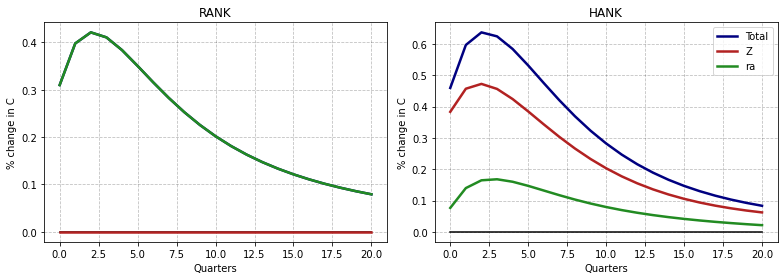

In [16]:
decomp_C([model_K_RA, model_K], names=['RANK', 'HANK'], do_cap_gain=False)

### 2.4. <a id='toc2_4_'></a>[d) Sticky expectations](#toc0_)

In [17]:
@nb.njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh


def E_sticky_exp(theta, T=300):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    E = np.triu(E, +1) + np.tril(np.ones((T, T)))
    return E

# Create expectations matrix 
E_sticky = E_sticky_exp(theta=0.95, T=model_K.par.T)

model_K_sticky = model_K.copy()
model_K_sticky_RA = model_K_RA.copy()

# Modify Jacobian 
for o in ['C_hh', 'A_hh']:
    for i in ['Z', 'ra']:
        model_K_sticky.jac_hh[(o,i)] = manipulate_separable(model_K_sticky.jac_hh[(o,i)].copy(), E_sticky)  
        model_K_sticky_RA.jac_hh[(o,i)] = manipulate_separable(model_K_sticky_RA.jac_hh[(o,i)].copy(), E_sticky) 


model_K_sticky.compute_jacs(skip_hh=True,skip_shocks=False)
model_K_sticky_RA.compute_jacs(skip_hh=True,skip_shocks=False)

model_K_sticky.find_IRFs(shocks=['eps_i'],do_print=False)
model_K_sticky_RA.find_IRFs(shocks=['eps_i'],do_print=False)

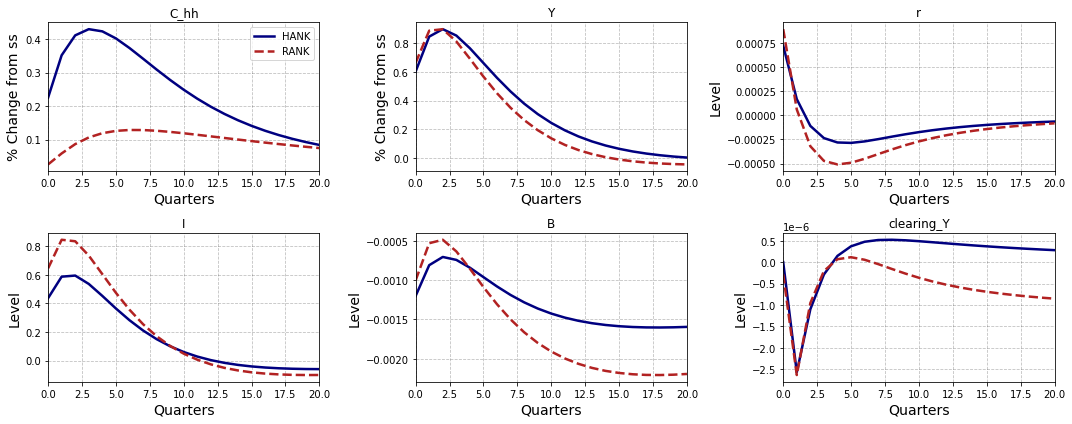

In [18]:
paths = ['C_hh', 'Y', 'r', 'I', 'B', 'clearing_Y']
plot_linear([model_K_sticky,model_K_sticky_RA], ['HANK','RANK'], paths, lvl_value=['pi', 'r', 'B', 'clearing_Y', 'I'],
            lw=2.5, T_max=21, ncols=3, colors=['navy', 'firebrick'], facs={'I' : 100.})

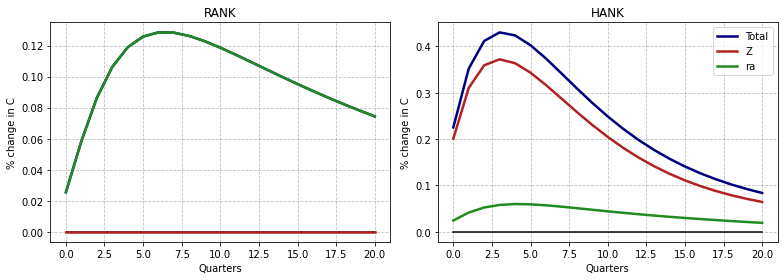

In [19]:
decomp_C([model_K_sticky_RA, model_K_sticky], names=['RANK', 'HANK'], do_cap_gain=False)

## 3. <a id='toc3_'></a>[Q3 - Fiscal Policy](#toc0_)

### 3.1. <a id='toc3_1_'></a>[a)](#toc0_)

Fiscal policy without investment 

In [20]:
omega = 0.03
model_NO_K.par.omega = omega
model_NO_K_RA.par.omega = omega
model_K.par.omega = omega
model_K_RA.par.omega = omega

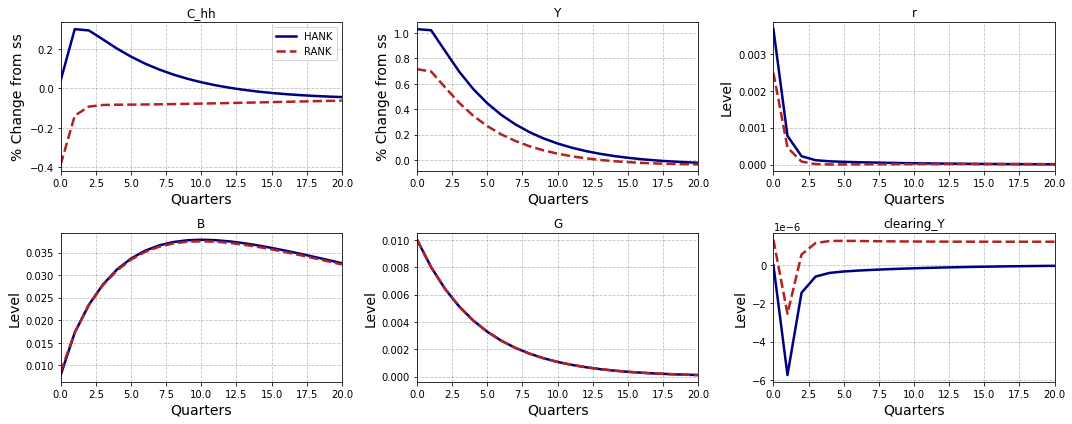

In [21]:
model_NO_K.compute_jacs(skip_hh=False,skip_shocks=False)
model_NO_K_RA.compute_jacs(skip_hh=True,skip_shocks=False)

model_NO_K.find_IRFs(shocks=['G'],do_print=False)
model_NO_K_RA.find_IRFs(shocks=['G'],do_print=False)

paths = ['C_hh', 'Y', 'r', 'B', 'G', 'clearing_Y']
plot_linear([model_NO_K,model_NO_K_RA], ['HANK','RANK'], paths, lvl_value=['pi', 'r', 'B', 'G', 'clearing_Y'],
            lw=2.5, T_max=21, ncols=3, colors=['navy', 'firebrick'])

Fiscal policy with investment

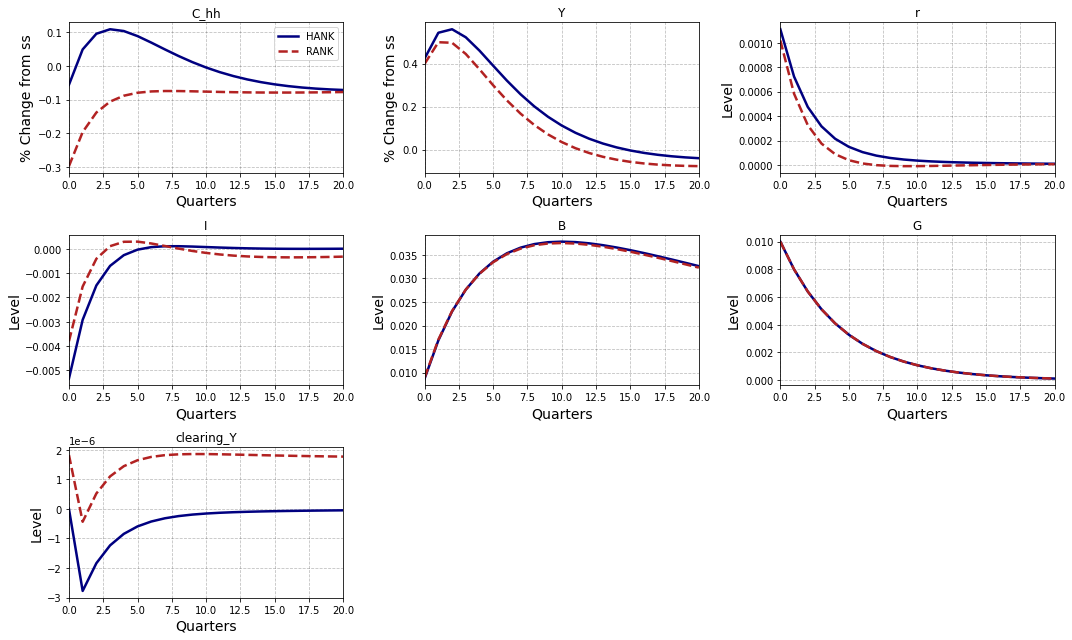

In [22]:
model_K.compute_jacs(skip_hh=False,skip_shocks=False)
model_K_RA.compute_jacs(skip_hh=True,skip_shocks=False)

model_K.find_IRFs(shocks=['G'],do_print=False)
model_K_RA.find_IRFs(shocks=['G'],do_print=False)

paths = ['C_hh', 'Y', 'r', 'I', 'B', 'G', 'clearing_Y']
plot_linear([model_K,model_K_RA], ['HANK','RANK'], paths, lvl_value=['pi', 'r', 'B', 'G', 'I', 'clearing_Y'],
            lw=2.5, T_max=21, ncols=3, colors=['navy', 'firebrick'])

### 3.2. <a id='toc3_2_'></a>[b) - Vary deficit financing](#toc0_)

In [23]:
omega_list = [0.03, 0.05, 0.08, 0.1, 0.3, 0.5, 0.8, 1.0]
N_omega = len(omega_list)
irfs = {'HANK' : {'model' : model_K, }, 
        'RANK' : {'model' : model_K_RA}}

T = model_K.par.T
for hh in irfs:
    
    irfs[hh]['Y'] = np.zeros((T,N_omega))
    irfs[hh]['C_hh'] = np.zeros((T,N_omega))
    irfs[hh]['I'] = np.zeros((T,N_omega))

omega_org = model_K.par.omega
for hh in irfs:
    
    model_ = irfs[hh]['model']

    for j,omega in enumerate(omega_list):
        model_.par.omega = omega
    
        model_.compute_jacs(skip_hh=True,skip_shocks=False)

        # Solve for G shock 
        model_.find_IRFs(shocks=['G'],do_print=False)

        irfs[hh]['Y'][:,j] = model_.IRF['Y']
        irfs[hh]['C_hh'][:,j] = model_.IRF['C_hh']
        irfs[hh]['I'][:,j] = model_.IRF['I']

# restore 
model_K.par.omega = omega_org
model_K_RA.par.omega = omega_org

# Cumulative dG 
dG = model_K.IRF['G']

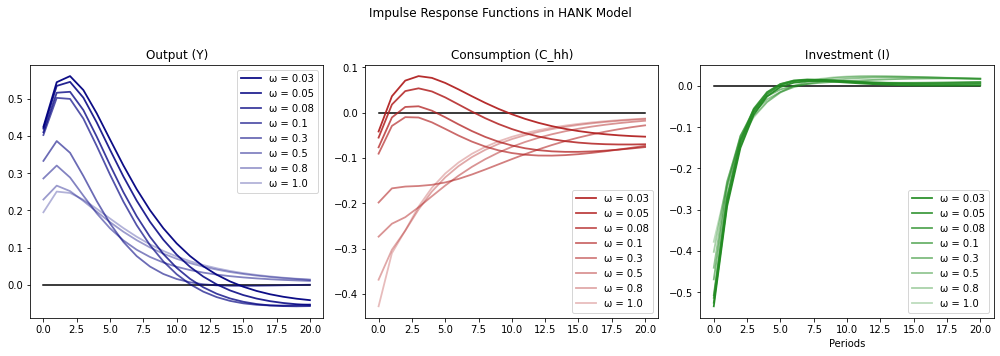

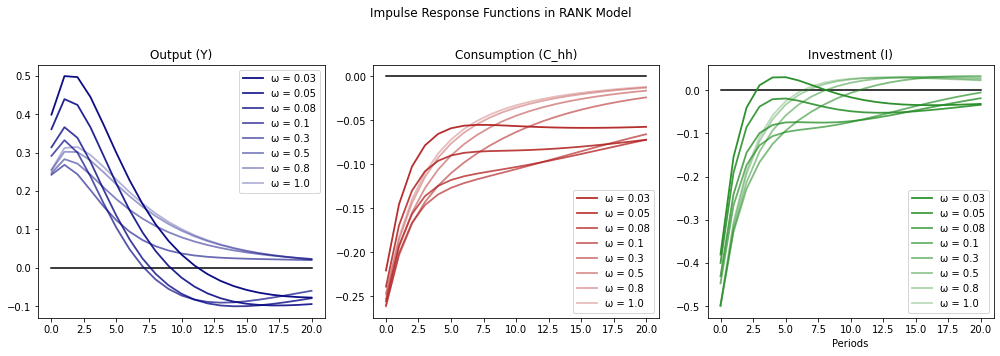

In [24]:
def plot_irfs(irfs, model_name, omega_list, num_periods=21, color=['navy', 'firebrick', 'forestgreen']):
    """
    Plots IRFs for Y, C_hh, and I for a specified model (HANK or RANK) over a specified number of periods.

    Parameters:
    - irfs (dict): Dictionary containing IRFs for HANK and RANK models.
    - model_name (str): The model to plot ('HANK' or 'RANK').
    - omega_list (list): List of omega values used in the model.
    - num_periods (int): Number of periods to plot (default is 21).
    """
    
    omega_labels = [f'ω = {omega}' for omega in omega_list]
    
    # Extract IRFs for the specified model
    Y_irf = irfs[model_name]['Y'][:num_periods, :]
    C_hh_irf = irfs[model_name]['C_hh'][:num_periods, :]
    I_irf = irfs[model_name]['I'][:num_periods, :]

    # Create a figure and axis objects
    fig, axes = plt.subplots(1,3, figsize=(14, 5), sharex=True)
    fig.suptitle(f'Impulse Response Functions in {model_name} Model')

    alpha_list = np.linspace(0.95,0.3,len(omega_list))

    # Plot each variable
    variables = [('Output (Y)', Y_irf), ('Consumption (C_hh)', C_hh_irf), ('Investment (I)', I_irf)]
    for i, (title, data) in enumerate(variables):
        axes[i].plot(np.zeros(num_periods), color='black')
        for j in range(len(omega_list)):
            axes[i].plot(data[:, j]*100, label=omega_labels[j], color=color[i], alpha=alpha_list[j], linewidth=1.8)
        # axes[i].set_ylabel(title)
        axes[i].set_title(title)
        axes[i].legend()
        axes[i].grid()

    # Set x-axis label for the last plot
    axes[-1].set_xlabel('Periods')

    # Show plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the function for both HANK and RANK models
plot_irfs(irfs, 'HANK', omega_list)
plot_irfs(irfs, 'RANK', omega_list)

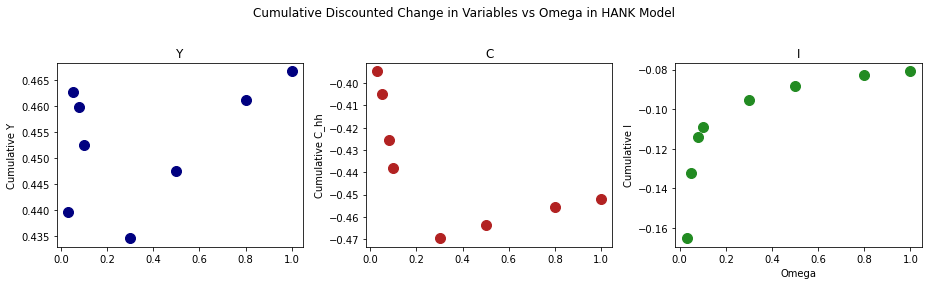

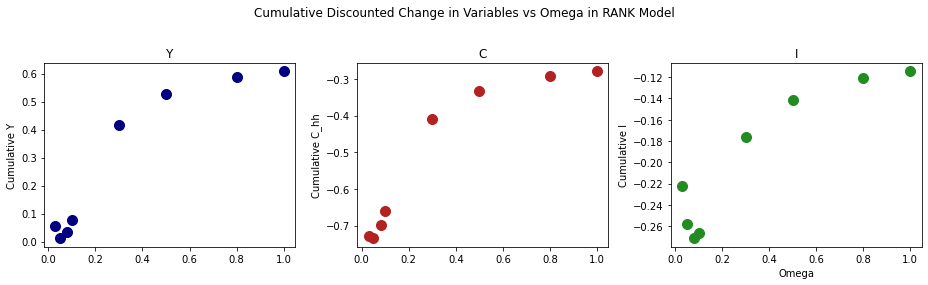

In [31]:
def plot_cumulative_discounted_change(irfs, model_name, omega_list, dG, discount_factor=0.95, 
                                      color=['navy', 'firebrick', 'forestgreen'], marker_size=10):

    # Prepare arrays to store cumulative discounted sums for each variable
    cumulative_Y = []
    cumulative_C_hh = []
    cumulative_I = []
    
    # Calculate the cumulative discounted sums for each omega value
    for j in range(len(omega_list)):
        # Apply discounting across periods
        discount_factors = discount_factor ** np.arange(irfs[model_name]['Y'].shape[0])
        
        # Compute discounted cumulative sum for each variable
        cum_Y = np.sum(irfs[model_name]['Y'][:, j] * discount_factors) / np.sum(dG*discount_factors)
        cum_C_hh = np.sum(irfs[model_name]['C_hh'][:, j] * discount_factors) / np.sum(dG*discount_factors)
        cum_I = np.sum(irfs[model_name]['I'][:, j] * discount_factors) / np.sum(dG*discount_factors)
        
        # Store results
        cumulative_Y.append(cum_Y)
        cumulative_C_hh.append(cum_C_hh)
        cumulative_I.append(cum_I)
    
    # Create subplots for each variable
    fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharex=True)
    fig.suptitle(f'Cumulative Discounted Change in Variables vs Omega in {model_name} Model')

    # Plot each variable in a separate subplot with dots
    axes[0].plot(omega_list, cumulative_Y, 'o', color=color[0], markersize=marker_size)
    axes[0].set_ylabel('Cumulative Y')
    axes[0].grid()
    axes[0].set_title('Y')

    axes[1].plot(omega_list, cumulative_C_hh, 'o', color=color[1], markersize=marker_size)
    axes[1].set_ylabel('Cumulative C_hh')
    axes[1].grid()
    axes[1].set_title('C')

    axes[2].plot(omega_list, cumulative_I, 'o', color=color[2], markersize=marker_size)
    axes[2].set_ylabel('Cumulative I')
    axes[2].set_xlabel('Omega')
    axes[2].grid()
    axes[2].set_title('I')

    # Show plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Call the function for both HANK and RANK models
plot_cumulative_discounted_change(irfs, 'HANK', omega_list, dG, discount_factor=1/(1+model_K.ss.r))
plot_cumulative_discounted_change(irfs, 'RANK', omega_list, dG, discount_factor=1/(1+model_K.ss.r))

In [28]:
1/(1+model_K.ss.r)

0.9950615774798433